In [ ]:
!pip install -q transformers datasets evaluate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.1 MB/s eta 0:00:00


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving test.jsonl to test.jsonl
Saving train.jsonl to train.jsonl


In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict

df_train = pd.read_json("train.jsonl", lines=True)
df_test = pd.read_json("test.jsonl", lines=True)

ds_train = Dataset.from_pandas(df_train)
ds_test = Dataset.from_pandas(df_test)

dataset = DatasetDict({
    "train": ds_train,
    "test": ds_test
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 8123
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 2031
    })
})


In [ ]:
label2id = {"non_incident": 0, "incident": 1}

def encode_labels(example):
    example["label"] = label2id[example["label"]]
    return example

dataset = dataset.map(encode_labels)
print(dataset["train"][0])

Map:   0%|          | 0/8123 [00:00<?, ? examples/s]

Map:   0%|          | 0/2031 [00:00<?, ? examples/s]

{'label': 0, 'text': "paramedic: Bonjour, un transporteur propose une PEC à 14h30. N'ayant pas d'autres propositions, nous bloquons ce créneau. N'hésitez pas à revenir vers nous si cela s'avère contraignant. Bien à vous. hi: OK MERCI"}


In [ ]:
from transformers import CamembertTokenizer

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
print(tokenized_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Map:   0%|          | 0/8123 [00:00<?, ? examples/s]

Map:   0%|          | 0/2031 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 8123
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 2031
    })
})


In [ ]:
from transformers import CamembertForSequenceClassification

model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base",
    num_labels=2
)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    warmup_steps=200,
    lr_scheduler_type="cosine",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.395900,0.281385,0.903003,0.893961
2,0.276200,0.260838,0.908912,0.905598


TrainOutput(global_step=1016, training_loss=0.3345382398977054, metrics={'train_runtime': 20531.4366, 'train_samples_per_second': 0.791, 'train_steps_per_second': 0.049, 'total_flos': 1068625551344640.0, 'train_loss': 0.3345382398977054, 'epoch': 2.0})

In [ ]:
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")

('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/sentencepiece.bpe.model',
 './final_model/added_tokens.json')


Classification report détaillé :
              precision    recall  f1-score   support

non_incident       0.93      0.96      0.95      1655
    incident       0.81      0.67      0.73       376

    accuracy                           0.91      2031
   macro avg       0.87      0.82      0.84      2031
weighted avg       0.91      0.91      0.91      2031



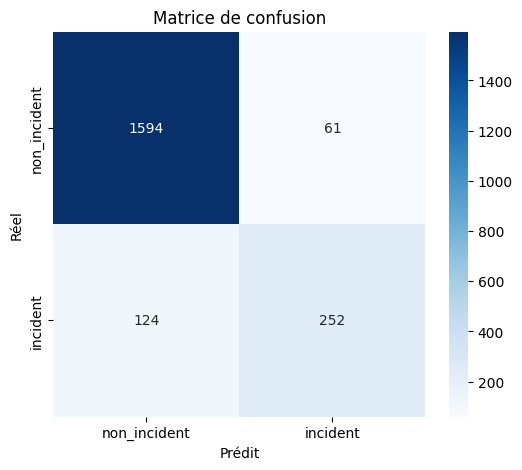

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = trainer.predict(tokenized_dataset["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("\nClassification report détaillé :")
print(classification_report(y_true, y_pred, target_names=["non_incident", "incident"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["non_incident", "incident"],
            yticklabels=["non_incident", "incident"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

In [ ]:
from google.colab import files
import shutil

shutil.make_archive("final_model", 'zip', "./final_model")

files.download("final_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>